In [1]:
import pandas as pd
import numpy as np 
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split


warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Input

The link to the drive
https://drive.google.com/file/d/1LxC97ESki0K652L8t2fASggaXyJcfS2y/view?usp=sharing


The link to the dataset in kaggle
https://www.kaggle.com/datasets/jangedoo/utkface-new

In [2]:
BASE_DIR = '/kaggle/input/utkface-new/UTKFace/'

In [3]:
gender_dict={0:'Male', 1:'Female'}


## Converting to the DataFrame

In [4]:
image_paths=[]
age_labels=[]
gender_labels=[]

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path=os.path.join(BASE_DIR, filename)
    temp=filename.split('_')
    age=int(temp[0])
    gender= int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [5]:
df=pd.DataFrame()
df['image'], df['age'],df['gender']=image_paths, age_labels, gender_labels
df.head()

,image,age,gender
0,/kaggle/input/utkface-new/UTKFace/26_0_2_20170...,26,0
1,/kaggle/input/utkface-new/UTKFace/22_1_1_20170...,22,1
2,/kaggle/input/utkface-new/UTKFace/21_1_3_20170...,21,1
3,/kaggle/input/utkface-new/UTKFace/28_0_0_20170...,28,0
4,/kaggle/input/utkface-new/UTKFace/17_1_4_20170...,17,1


## Dataset Split before the Data Augmentation

In [6]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

print(f"Training set size: {len(train_df)}")
print(f"Testing set size: {len(test_df)}")


Training set size: 18966
Testing set size: 4742


## Data Augmentation

In [7]:
train_aug_dir = "augmented_train_images"
os.makedirs(train_aug_dir, exist_ok=True)

for _, row in train_df.iterrows():
    file_path = row['image']
    img = Image.open(file_path)
    base_filename = os.path.basename(file_path).split('.')[0]

    img.save(os.path.join(train_aug_dir, f"{base_filename}_orig.jpg"))

    img.rotate(90).save(os.path.join(train_aug_dir, f"{base_filename}_90.jpg"))
    img.rotate(180).save(os.path.join(train_aug_dir, f"{base_filename}_180.jpg"))
    img.rotate(270).save(os.path.join(train_aug_dir, f"{base_filename}_270.jpg"))


In [8]:
rotated_dir='/kaggle/working/augmented_train_images'

## Plot some of them

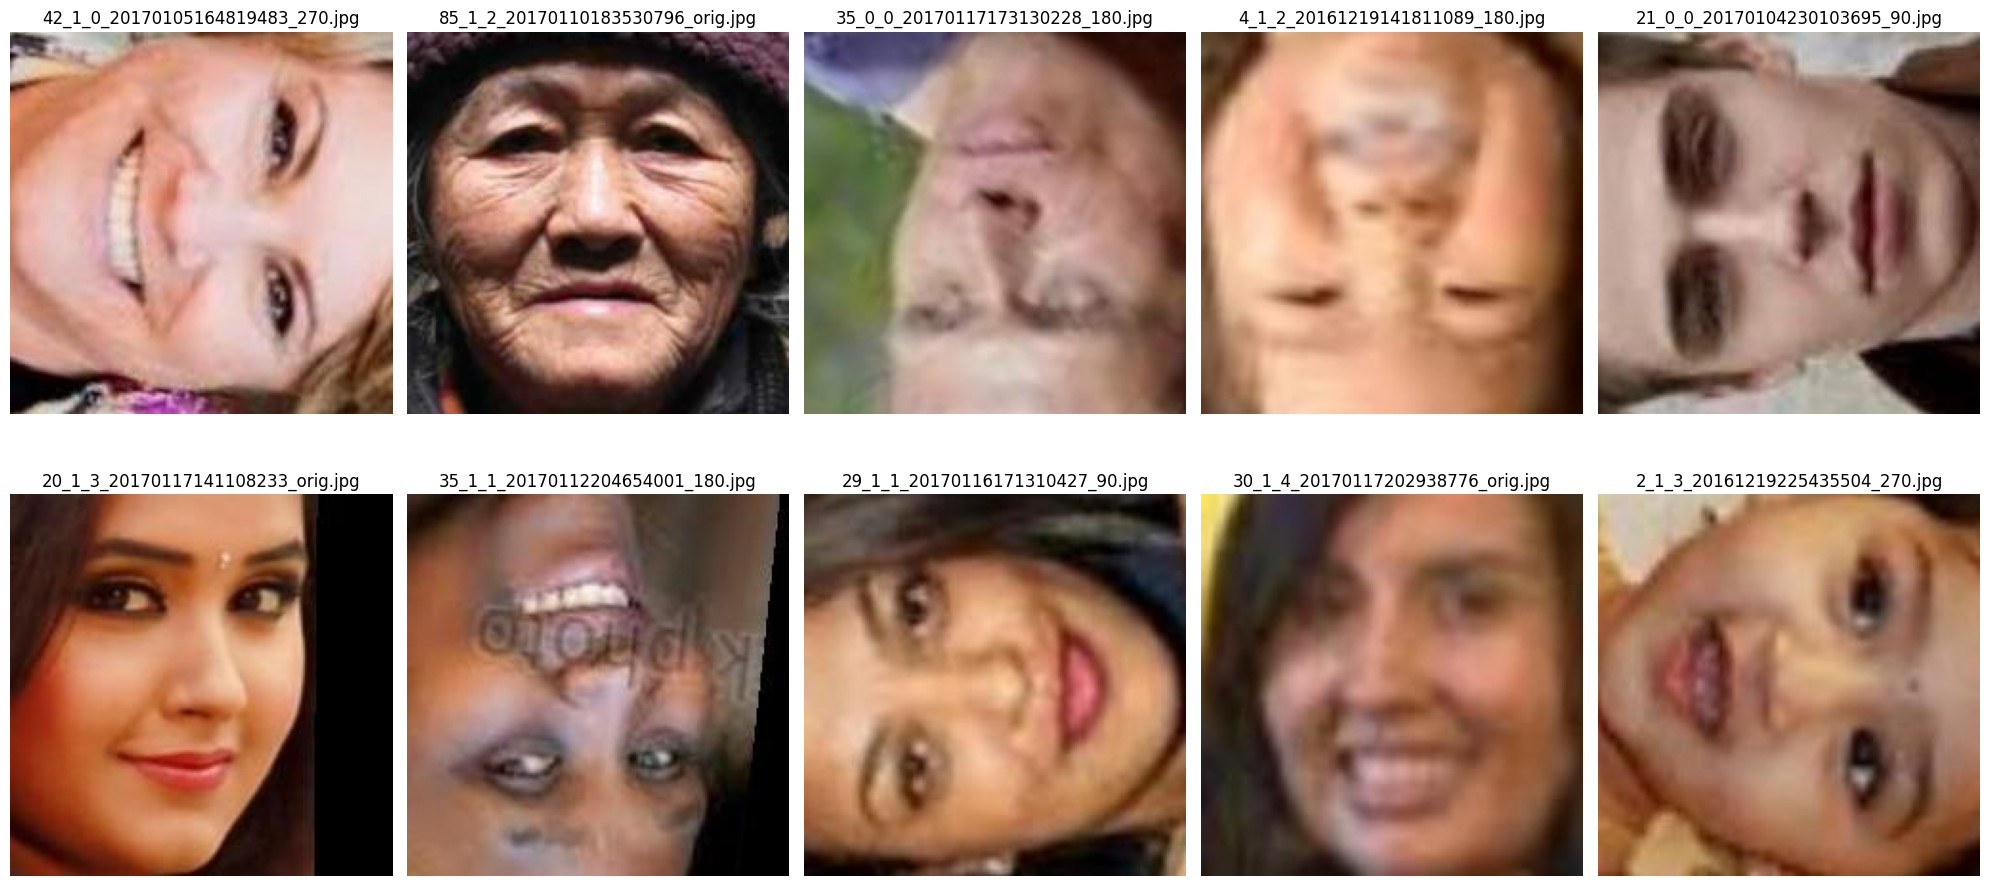

In [32]:
import random
augmented_dir = "/kaggle/working/augmented_train_images"  # Замените на путь вашей директории

augmented_images = os.listdir(augmented_dir)

random_images = random.sample(augmented_images, 10)

# Отображение выбранных изображений
plt.figure(figsize=(20, 10))
for i, img_file in enumerate(random_images):
    img_path = os.path.join(augmented_dir, img_file)
    img = load_img(img_path)  # Загрузка изображения
    plt.subplot(2, 5, i + 1)  # 2 строки, 5 столбцов для 10 изображений
    plt.imshow(img)
    plt.title(img_file)  # Отображение имени файла
    plt.axis('off')

plt.tight_layout()
plt.show()


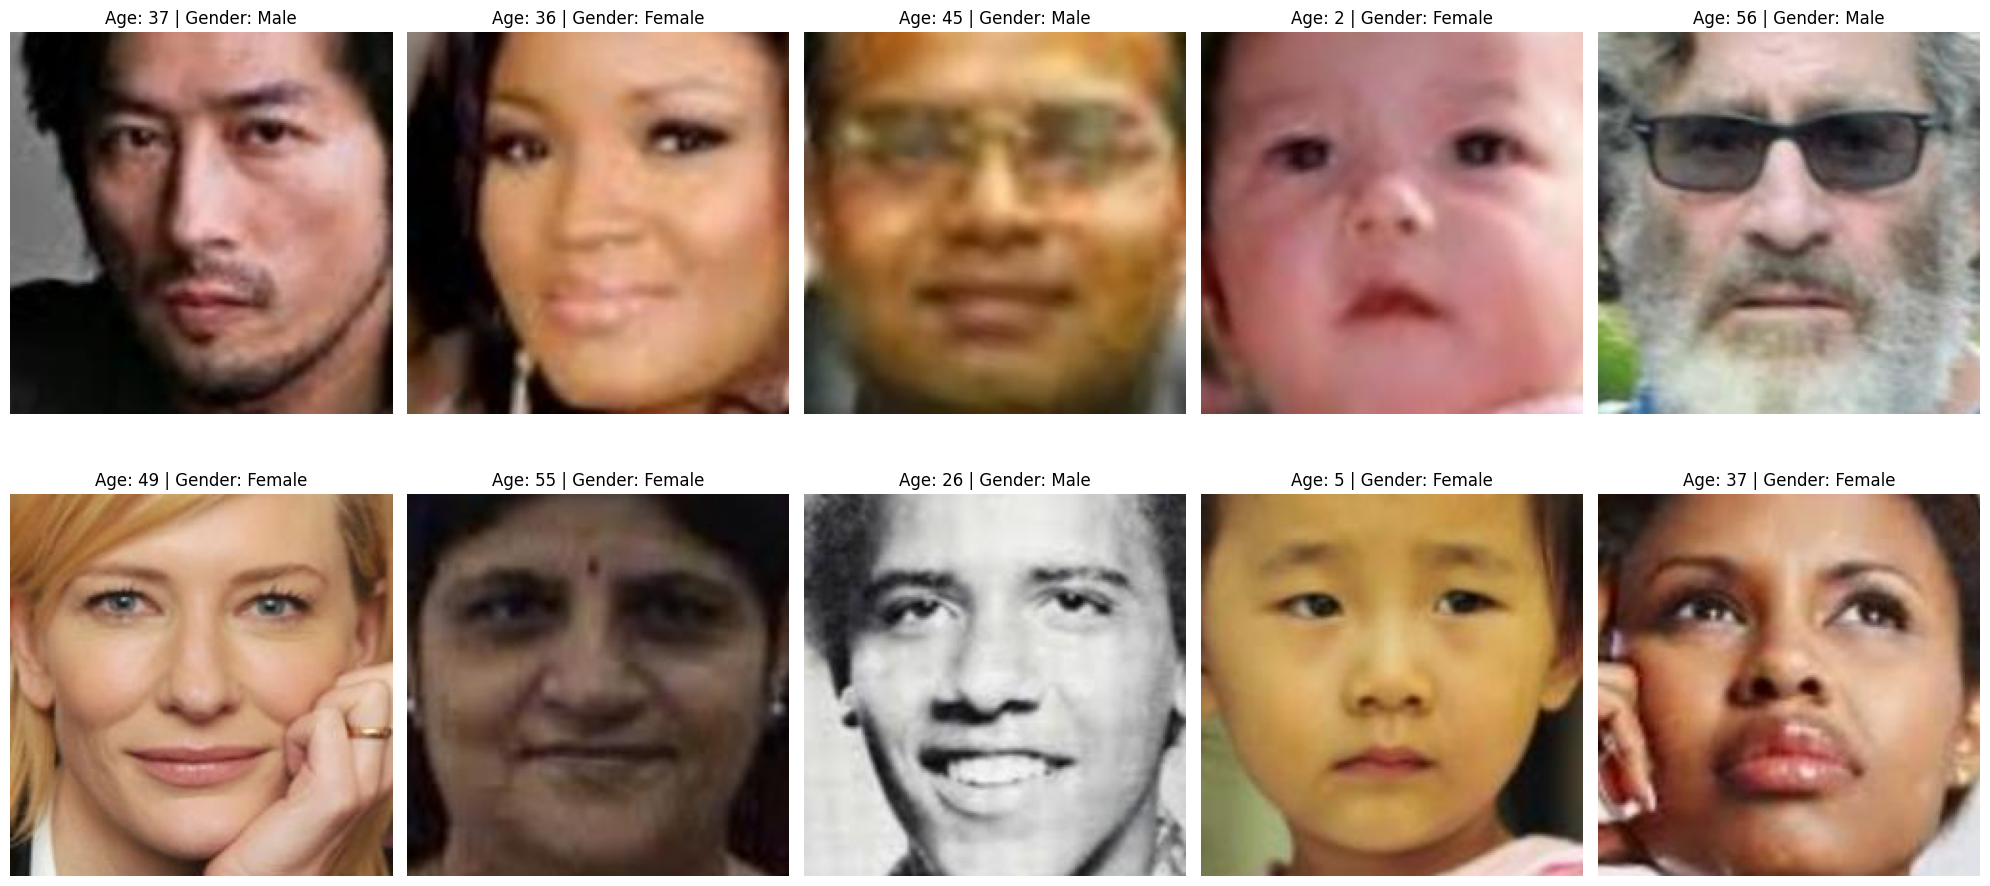

In [10]:
random_test_samples = test_df.sample(10)

# Plot the selected images
plt.figure(figsize=(20, 10))
for i, (_, row) in enumerate(random_test_samples.iterrows()):
    img_path = row['image']  # Assuming 'image' column contains the image paths
    img = load_img(img_path)  # Load the image
    plt.subplot(2, 5, i + 1)  # 2 rows, 5 columns
    plt.imshow(img)
    plt.title(f"Age: {row['age']} | Gender: {gender_dict[row['gender']]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [11]:
from collections import Counter


In [12]:
augmented_images = []
augmented_ages = []
augmented_gender = []

for filename in tqdm(os.listdir(rotated_dir)):  # Disable widget mode
    image_path = os.path.join(rotated_dir, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    augmented_images.append(image_path)
    augmented_ages.append(age)
    augmented_gender.append(gender)

# Create the DataFrame
df_aug = pd.DataFrame()
df_aug['image'], df_aug['age'], df_aug['gender'] = augmented_images, augmented_ages, augmented_gender


  0%|          | 0/75864 [00:00<?, ?it/s]

In [13]:
df_aug.shape

(75864, 3)

In [14]:
test_dir = "test_df"
os.makedirs(test_dir, exist_ok=True)

for _, row in test_df.iterrows():
    file_path = row['image']
    img = Image.open(file_path)
    base_filename = os.path.basename(file_path)
    img.save(os.path.join(test_dir, base_filename))


## Feature Extraction

In [15]:
def extract_features(images):
    features=[]
    for image in tqdm(images):
        img=load_img(image,color_mode='grayscale')
        img=img.resize((128,128), Image.Resampling.LANCZOS)
        img=np.array(img)
        features.append(img)
    features=np.array(features)
    features=features.reshape(len(features),128,128,1)
    return features

In [16]:
X_train_aug=extract_features(df_aug['image'])

  0%|          | 0/75864 [00:00<?, ?it/s]

In [17]:
X_train_aug.shape

(75864, 128, 128, 1)

In [18]:
y_train_gender = np.array(df_aug['gender'])
y_train_age = np.array(df_aug['age'])

X_test = extract_features(test_df['image'])
y_test_gender = np.array(test_df['gender'])
y_test_age = np.array(test_df['age'])


  0%|          | 0/4742 [00:00<?, ?it/s]

In [19]:
X_train = X_train_aug / 255.0
X_test = X_test / 255.0


In [20]:
input_shape=(128,128,1) 

In [21]:
inputs=Input((input_shape))
# Convolutional Layers
conv_1=Conv2D(32,kernel_size=(3,3),activation='relu')(inputs)
maxp_1=MaxPooling2D(pool_size=(2,2))(conv_1)
conv_2=Conv2D(64,kernel_size=(3,3),activation='relu')(maxp_1)
maxp_2=MaxPooling2D(pool_size=(2,2))(conv_2)
conv_3=Conv2D(128,kernel_size=(3,3),activation='relu')(maxp_2)
maxp_3=MaxPooling2D(pool_size=(2,2))(conv_3)
conv_4=Conv2D(256,kernel_size=(3,3),activation='relu')(maxp_3)
maxp_4=MaxPooling2D(pool_size=(2,2))(conv_4)

flatten = Flatten() (maxp_4)

dense_1 = Dense(256, activation='relu') (flatten)
dense_2 = Dense(256, activation='relu') (flatten)


dropout_1 = Dropout(0.3) (dense_1)
dropout_2 = Dropout(0.3) (dense_2)

output_1 = Dense(1, activation = 'sigmoid', name = 'gender_out') (dropout_1)
output_2 = Dense(1, activation = 'relu', name = 'age_out') (dropout_2)

model =Model(inputs=[inputs],outputs=[output_1,output_2])

model.compile(loss=['binary_crossentropy', 'mae'], optimizer = 'adam', metrics = ['accuracy', 'mae']) 


In [22]:
# Проверка баланса классов
from collections import Counter

print("Train gender distribution:", Counter(y_train_gender))
print("Validation gender distribution:", Counter(y_test_gender))


Train gender distribution: Counter({0: 39564, 1: 36300})
Validation gender distribution: Counter({0: 2500, 1: 2242})


In [23]:
history = model.fit(
    x=X_train, 
    y=[y_train_gender, y_train_age], 
    batch_size=32, 
    epochs=20, 
    validation_data=(X_test, [y_test_gender, y_test_age])
)


Epoch 1/20


I0000 00:00:1732369881.666579     105 service.cc:145] XLA service 0x582aa8cdf7e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732369881.666640     105 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1732369881.666646     105 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


   9/2371 ━━━━━━━━━━━━━━━━━━━━ 36s 15ms/step - age_out_mae: 24.7789 - gender_out_accuracy: 0.5146 - loss: 25.6106  

I0000 00:00:1732369891.243602     105 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2371/2371 ━━━━━━━━━━━━━━━━━━━━ 60s 20ms/step - age_out_mae: 14.5402 - gender_out_accuracy: 0.6016 - loss: 15.1917 - val_age_out_mae: 9.8072 - val_gender_out_accuracy: 0.8007 - val_loss: 10.2413
Epoch 2/20
2371/2371 ━━━━━━━━━━━━━━━━━━━━ 37s 15ms/step - age_out_mae: 9.8198 - gender_out_accuracy: 0.8050 - loss: 10.2429 - val_age_out_mae: 8.5376 - val_gender_out_accuracy: 0.8387 - val_loss: 8.8815
Epoch 3/20
2371/2371 ━━━━━━━━━━━━━━━━━━━━ 38s 16ms/step - age_out_mae: 8.2760 - gender_out_accuracy: 0.8356 - loss: 8.6323 - val_age_out_mae: 7.5236 - val_gender_out_accuracy: 0.8492 - val_loss: 7.8554
Epoch 4/20
2371/2371 ━━━━━━━━━━━━━━━━━━━━ 37s 16ms/step - age_out_mae: 7.5485 - gender_out_accuracy: 0.8565 - loss: 7.8662 - val_age_out_mae: 7.6587 - val_gender_out_accuracy: 0.8671 - val_loss: 7.9456
Epoch 5/20
2371/2371 ━━━━━━━━━━━━━━━━━━━━ 37s 16ms/step - age_out_mae: 7.0886 - gender_out_accuracy: 0.8719 - loss: 7.3808 - val_age_out_mae: 7.0543 - val_gender_out_accuracy: 0.8815 - val_loss: 7.32

In [24]:
print(history.history.keys())

dict_keys(['age_out_mae', 'gender_out_accuracy', 'loss', 'val_age_out_mae', 'val_gender_out_accuracy', 'val_loss'])


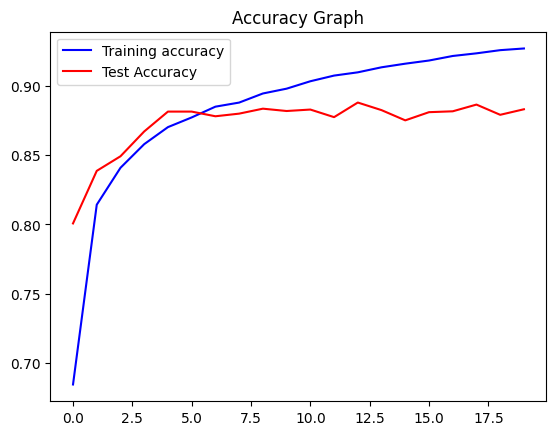

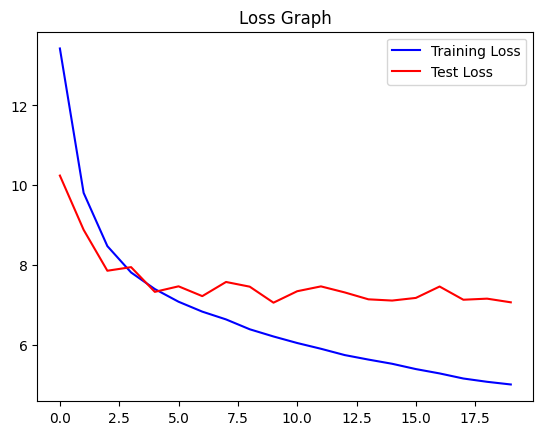

In [25]:
# Plot results for the gender
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs=range(len(acc))

plt.plot(epochs, acc, 'b', label ='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Test Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Test Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()


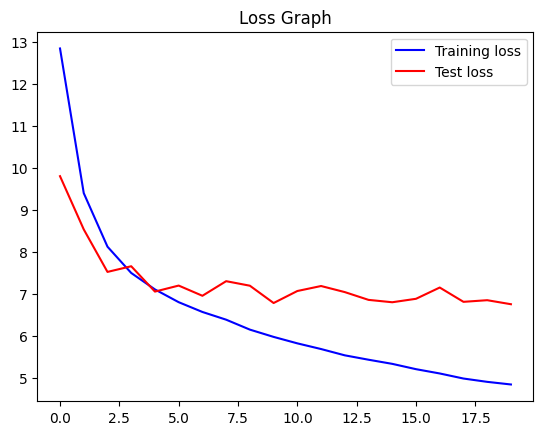

In [26]:
loss = history.history['age_out_mae']
val_loss = history.history['val_age_out_mae']
epochs=range(len(loss))

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Test loss')
plt.title('Loss Graph')
plt.legend()
plt.show()


In [33]:
predictions = model.predict(X_test)
predicted_genders = predictions[0]  # Gender predictions (output from sigmoid layer)
predicted_ages = predictions[1]  # Age predictions (output from relu layer)


149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


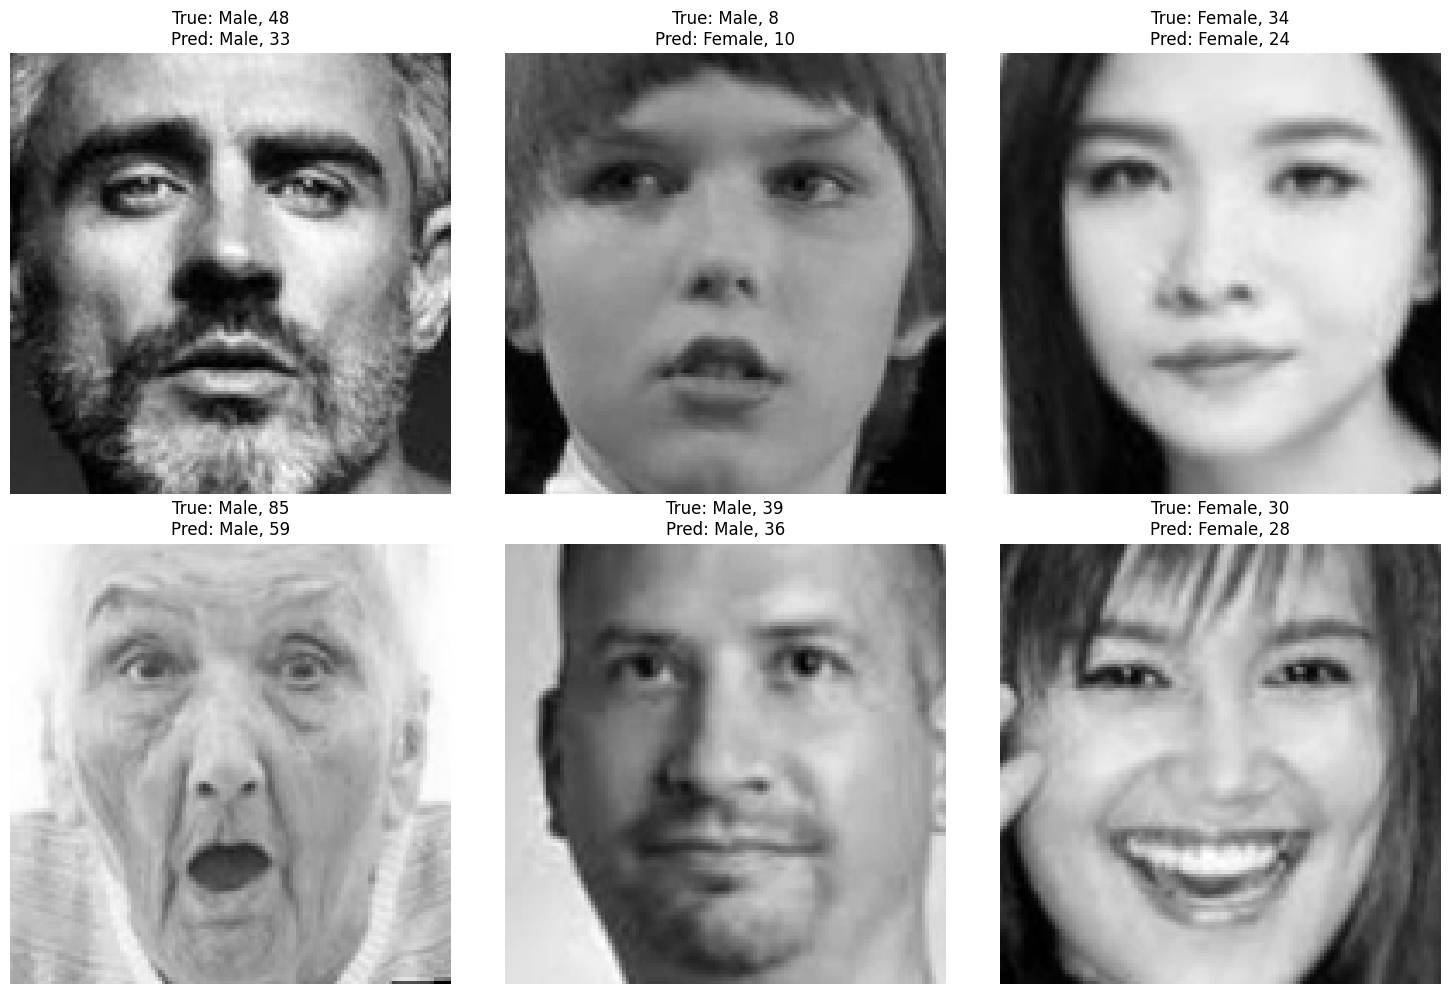

In [37]:
# Generate 6 random indices from the test set
random_indices = random.sample(range(len(X_test)), 6)

plt.figure(figsize=(15, 10))
for i, idx in enumerate(random_indices):
    plt.subplot(2, 3, i + 1)
    
    # Display the image
    img = X_test[idx].reshape(128, 128)  # Assuming grayscale images
    plt.imshow(img, cmap="gray")
    
    # Get predictions and true values
    predicted_gender = "Female" if predicted_genders[idx] > 0.5 else "Male"
    true_gender = "Male" if y_test_gender[idx] == 0 else "Female"
    predicted_age = round(predicted_ages[idx].item())  # Round the predicted age
    true_age = y_test_age[idx]
    
    # Set the title
    plt.title(f"True: {true_gender}, {true_age}\nPred: {predicted_gender}, {predicted_age}")
    plt.axis("off")

plt.tight_layout()
plt.show()



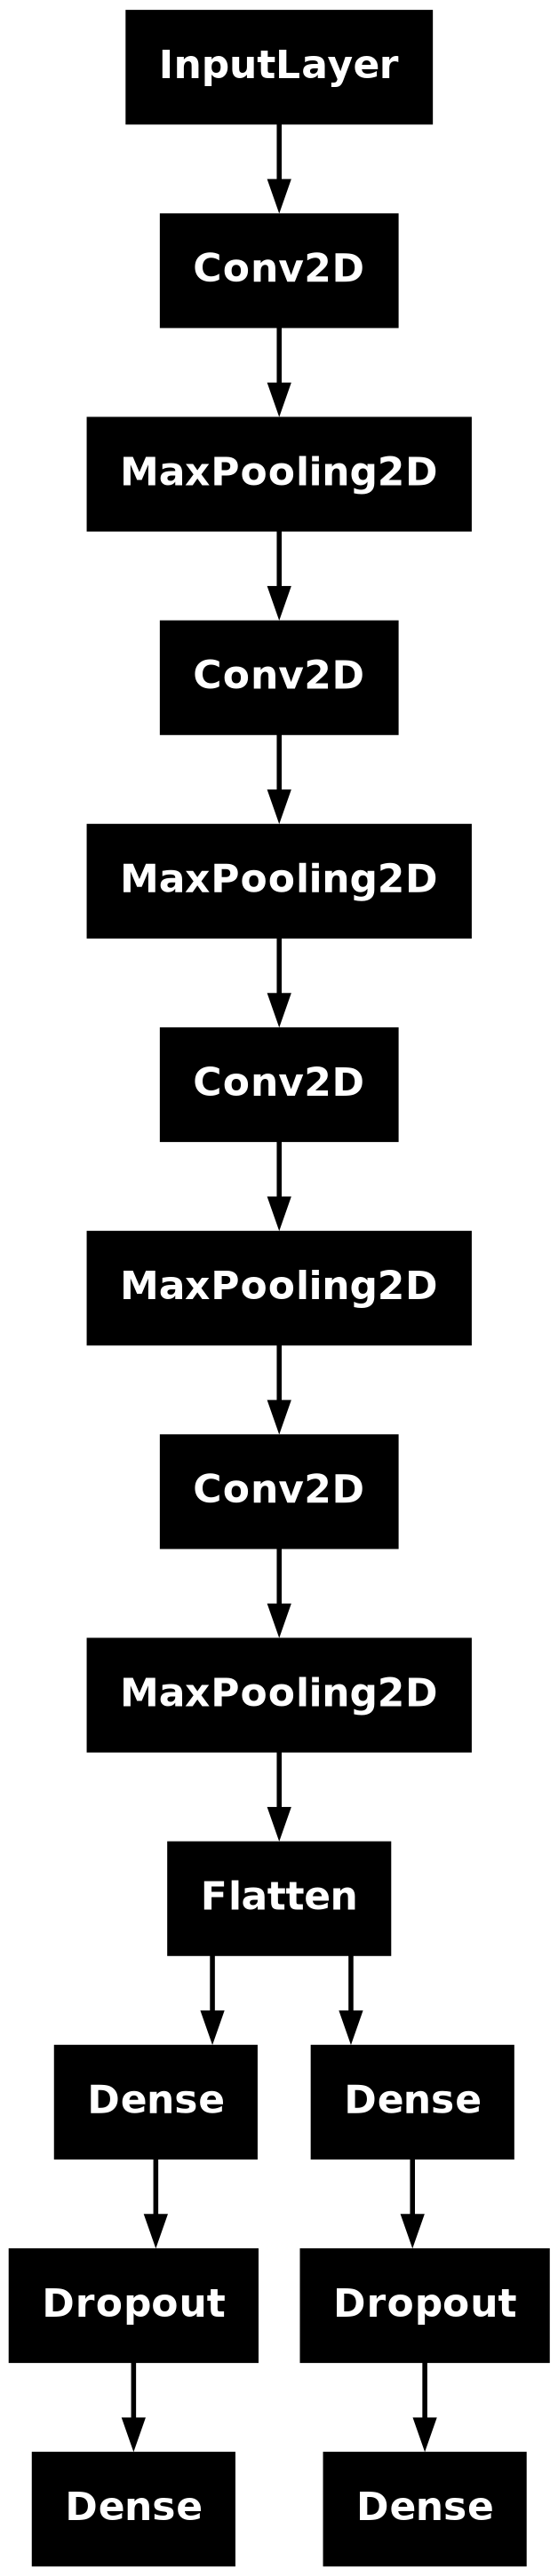

In [38]:
from keras.utils import plot_model
plot_model(model)

In [39]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 126, 126,  │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 63, 63,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 61, 61,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 30, 30,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 28, 28,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 14, 14,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 12, 12,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 6, 6, 256) │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 9216)      │          0 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │  2,359,552 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │  2,359,552 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gender_out (Dense)  │ (None, 1)         │        257 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ age_out (Dense)     │ (None, 1)         │        257 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 15,322,376 (58.45 MB)

 Trainable params: 5,107,458 (19.48 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 10,214,918 (38.97 MB)